<a href="https://colab.research.google.com/github/Disha1203/Privacy-preserving-FL/blob/main/iid_data_Basic_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y ray flwr
!pip install -U "ray==2.31.0" "flwr[simulation]==1.12.0"

Found existing installation: ray 2.31.0
Uninstalling ray-2.31.0:
  Successfully uninstalled ray-2.31.0
Found existing installation: flwr 1.12.0
Uninstalling flwr-1.12.0:
  Successfully uninstalled flwr-1.12.0
  Using cached ray-2.31.0-cp312-cp312-manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached flwr-1.12.0-py3-none-any.whl.metadata (15 kB)
Using cached ray-2.31.0-cp312-cp312-manylinux2014_x86_64.whl (66.7 MB)
Using cached flwr-1.12.0-py3-none-any.whl (478 kB)


In [17]:
import os, random, glob, time, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import flwr as fl
from flwr.common import parameters_to_ndarrays
from sklearn.metrics import roc_auc_score, accuracy_score

In [18]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Directories
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# FL hyperparameters
NUM_CLIENTS = 4
NUM_ROUNDS = 3
EPOCHS_PER_CLIENT = 1
BATCH_SIZE = 32

Device: cpu


In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np # Import numpy

# Load the combined dataset
combined = pd.read_csv('/content/Dataset.csv')

# Splitting the dataset into test and train according to patient_id
rows_to_drop_train = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop_train.index).copy() # Use .copy() to avoid SettingWithCopyWarning

rows_to_drop_test = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop_test.index).copy() # Use .copy() to avoid SettingWithCopyWarning


# Remove rows with NaN values in the target variable for both train and test sets
df_train.dropna(subset=['SepsisLabel'], inplace=True)
df_test.dropna(subset=['SepsisLabel'], inplace=True)

# Assume 'SepsisLabel' is the target
X_train = df_train.drop(columns=['SepsisLabel', 'Patient_ID'])  # remove ID
y_train = df_train['SepsisLabel'].values

X_test = df_test.drop(columns=['SepsisLabel', 'Patient_ID'])  # remove ID
y_test = df_test['SepsisLabel'].values


# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
# Use the same imputer fitted on the training data to transform the test data
X_test = imputer.transform(X_test)


# Optional: standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# Use the same scaler fitted on the training data to transform the test data
X_test = scaler.transform(X_test)


# Convert to torch datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (63497, 41)
Shape of X_test: (52161, 41)
Shape of y_train: (63497,)
Shape of y_test: (52161,)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['EtCO2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['EtCO2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:

client_size = len(train_dataset) // NUM_CLIENTS
lengths = [client_size]*(NUM_CLIENTS-1)
lengths.append(len(train_dataset) - sum(lengths))
client_datasets = random_split(train_dataset, lengths)
client_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:


NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 2

class SepsisNet(nn.Module):
    def __init__(self, num_features=NUM_FEATURES, num_classes=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [22]:
def dump_outputs(model, loader, path_prefix):
    """Save softmax probs and labels for all examples in loader to path_prefix.npz"""
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            probs = F.softmax(out, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(yb.numpy())
    if all_probs:
        probs = np.vstack(all_probs)
        labels = np.concatenate(all_labels)
    else:
        probs = np.zeros((0, NUM_CLASSES))
        labels = np.zeros((0,), dtype=int)
    np.savez_compressed(f"{path_prefix}.npz", probs=probs, labels=labels)
    return f"{path_prefix}.npz"


In [23]:
class SepsisClient(fl.client.NumPyClient):
    def __init__(self, model, trainloader, testloader, cid):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.cid = cid
        self.log_prefix = os.path.join(LOG_DIR, f"client_{cid}")

    def get_parameters(self, config):
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters):
        state_dict = dict(zip(self.model.state_dict().keys(), [torch.tensor(p) for p in parameters]))
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(DEVICE)
        self.model.train()
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001)
        crit = nn.CrossEntropyLoss()
        for _ in range(EPOCHS_PER_CLIENT):
            for x,y in self.trainloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                opt.zero_grad()
                loss = crit(self.model(x), y)
                loss.backward()
                opt.step()
        # Dump outputs for attack evaluation (optional)
        round_no = config.get("round", 0)
        dump_outputs(self.model, self.trainloader, os.path.join(LOG_DIR, f"client_{self.cid}_train_outputs_round{round_no}"))
        dump_outputs(self.model, self.testloader, os.path.join(LOG_DIR, f"client_{self.cid}_test_outputs_round{round_no}"))
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(DEVICE).eval()
        crit = nn.CrossEntropyLoss()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x,y in self.testloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = self.model(x)
                total_loss += crit(out, y).item()
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = correct/total
        return total_loss/len(self.testloader), total, {"accuracy": acc}


In [24]:
class LoggingFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated = super().aggregate_fit(rnd, results, failures)
        if aggregated is None:
            return None
        parameters, num_examples = aggregated
        try:
            ndarrays = parameters_to_ndarrays(parameters)
            model = SepsisNet()
            keys = list(model.state_dict().keys())
            state_dict = {k: torch.tensor(p) for k, p in zip(keys, ndarrays)}
            save_path = os.path.join(LOG_DIR, f"global_model_round{rnd}.pth")
            torch.save(state_dict, save_path)
            print(f"Saved global model state for round {rnd} -> {save_path}")
        except Exception as e:
            print("Warning: could not save global model state:", e)
        return aggregated


In [25]:
def client_fn(cid: str):
    model = SepsisNet()
    cid_int = int(cid)
    return SepsisClient(model, client_loaders[cid_int], test_loader, cid)

strategy = LoggingFedAvg()
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)


INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2025-10-18 08:29:28,423	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3977634201.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7955268404.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEn

Saved global model state for round 1 -> logs/global_model_round1.pth


(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=3490) 
(ClientAppActor pid=3490)         
(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=3490) 
(ClientAppActor pid=3490)         
(ClientAppActor pid=3490) 
(ClientAppActor pid=3490)         
(ClientAppActor pid=3490) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=3490)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=3490)             enti

Saved global model state for round 2 -> logs/global_model_round2.pth


(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=3490) 
(ClientAppActor pid=3490)         
(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=3489) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=3489)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=3489)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=3489) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
(ClientAppActor pid=

Saved global model state for round 3 -> logs/global_model_round3.pth


(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=3489) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=3489)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=3489)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=3489) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=3490) 
(ClientAppActor pid=3490)         
(ClientAppActor pid=3489) 
(ClientAppActor pid=3489)         
(ClientAppActor pid=

History (loss, distributed):
	round 1: 0.09949585419032987
	round 2: 0.09144954496900505
	round 3: 0.08999194305928371

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [26]:
# Load the final global model state
final_model_path = os.path.join(LOG_DIR, f"global_model_round{NUM_ROUNDS}.pth")
final_model_state_dict = torch.load(final_model_path)

# Instantiate the model and load the state dictionary
final_global_model = SepsisNet()
final_global_model.load_state_dict(final_model_state_dict)

# Instantiate a dummy SepsisClient to use its evaluate method
# We only need the evaluate method, so train_loader is not used here.
dummy_client = SepsisClient(final_global_model, client_loaders[0], test_loader, cid="dummy")

# Evaluate the final global model
loss, num_examples, metrics = dummy_client.evaluate(
    dummy_client.get_parameters({}),  # Get parameters from the loaded model
    {} # Empty config
)

print(f"Evaluation loss on test set: {loss}")
print(f"Evaluation accuracy on test set: {metrics['accuracy']}")

Evaluation loss on test set: 0.08999194305928371
Evaluation accuracy on test set: 0.9802342746496424


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     51131
           1       0.04      0.00      0.00      1030

    accuracy                           0.98     52161
   macro avg       0.51      0.50      0.50     52161
weighted avg       0.96      0.98      0.97     52161

AUC: 0.7531


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


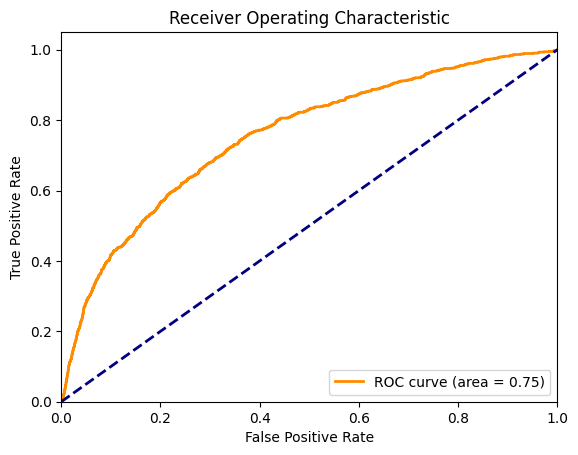

In [27]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure the model is on the correct device and in evaluation mode
final_global_model.to(DEVICE).eval()

# Pre-allocate arrays for results
num_test_samples = len(test_loader.dataset)
all_labels = np.zeros(num_test_samples, dtype=int)
all_preds = np.zeros(num_test_samples, dtype=int)
all_probs = np.zeros(num_test_samples, dtype=float)

current_idx = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        outputs = final_global_model(X_batch)

        # Get probabilities for the positive class (assuming index 1 is positive)
        probs = torch.sigmoid(outputs).cpu().numpy()[:, 1]
        preds = (probs >= 0.5).astype(int)
        labels = y_batch.cpu().numpy().flatten()

        batch_size = len(labels)
        all_labels[current_idx : current_idx + batch_size] = labels
        all_preds[current_idx : current_idx + batch_size] = preds
        all_probs[current_idx : current_idx + batch_size] = probs

        current_idx += batch_size


# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()